In [1]:
import librosa
import datetime
import pandas as pd
from librosa.effects import pitch_shift
import os
from sklearn.metrics import classification_report, recall_score,precision_score,accuracy_score,f1_score
import pathlib
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc, melspectrogram
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from research.dataImporting import MLtools
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, Conv2D, SeparableConv1D, MaxPooling1D,MaxPooling2D, Flatten, Dense, Dropout, AlphaDropout, \
    BatchNormalization, Activation, LSTM, Lambda, Reshape, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from research.dataImporting import dataTools
import keras.backend as K
from tcn import TCN
from keras import regularizers

# Training ML Models for use in EVP

In [5]:
training_df=pd.read_csv(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\MLModels\datasets\LT80m_detection_training_w_matrice_phantom.csv")

In [3]:
# notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range','MFCC_Values']
#
# def rename_bulk_columns(DF,nameList):
#     for x in range(len(nameList)):
#         DF.columns.values[x]=nameList[x]
# rename_bulk_columns(training_df,notable_col_names)
#
# training_df.to_csv("LT80m_detection_training_w_matrice_phantom_noise_augment_A1_A2_A3.csv")

In [6]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29", "Phone_3-1","Phone_3-2","Phone_3-3","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3"]
good_runs_phantom=["A2R5P1","A2R5P2","A2R5P3","A2R5P4","A2R5P5","A2R6P1","A2R6P2","A2R6P3","A2R6P4","A2R6P5"]
good_runs_mavic=["A2R7P1","A2R7P2","A2R7P3","A2R7P4","A2R7P5","A2R8P1","A2R8P2","A2R8P3","A2R8P4","A2R8P5","A3R6P1"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A2_A3_training_w_Matrice_Phantom.csv")
x_data=[]
y_data=[]
total_ranges=[]
aug_vals=[7000,7200,7400,7600,7800,8000,8200,8400,8600,8800,9000]
indiv_phone_num_dict={}
for x in phone_slots:
    indiv_phone_num_dict[x]=0
def melspect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    # spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    spect = melspectrogram(y=data,sr=Fs)
    return spect
def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    coefs = mfcc(y=data, hop_length=1024,n_mfcc=20, sr=Fs) #was 40
    #coefs = mfcc(y=data, hop_length=2048,n_fft=2048,n_mfcc=40, sr=Fs)
    return coefs

def crankThat(audioData):
    audio_amp=[1.0,1.1,1.2,1.3,1.4,1.5]
    audio_frames=[]
    class_val=[]
    for x in audio_amp:
        new_data=audioData*x
        mfcc_data=MFCCCalc(new_data,8000)
        audio_frames.append(mfcc_data.squeeze())
        class_val.append(1)
    return audio_frames, class_val
x_data=[]
y_data=[]
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    if scenario== "plsno":
        for x in aug_vals:
            full_aug_name=full_name+"_"+str(x).strip()
            print(full_aug_name)
            pass_df=training_df.loc[training_df['Pass'] == full_aug_name]
            max_segment=pass_df['Segment'].max()
            for phone in phone_slots:
                phone_seg=pass_df.loc[pass_df['Phone']==phone]
                twd_frame=[]
                range_frame=[]
                for i in range(0,max_segment):
                    frame_df=phone_seg.loc[phone_seg['Segment']==i]
                    data=np.array(frame_df.iloc[:,8:2056])
                    if np.any(data):
                        mel_data=data[0]
                    dist=frame_df['Range']
                    distance_val=np.array(dist)
                #dist=phone_seg["Range"]
                    if len(distance_val)>0:
                        dist=distance_val[0]
                        if dist<78:
                            #data=data[0]
                            #frames,class_values=crankThat(mel_data)
                            total_ranges.append(dist)
                            #data=np.reshape(data,(64,4))
                            #data=np.reshape(data,(40,1))
                            class_value=1
                            twd_frame.append(np.squeeze(mel_data))
                            range_frame.append(class_value)
                        elif 82< dist:
                            #data=np.reshape(data,(64,4))
                            #data=np.reshape(data,(40,1))
                            class_value=0
                            twd_frame.append(np.squeeze(mel_data))
                            range_frame.append(class_value)
                #y_vals= rangeClosest(range_frame)
                x_data.extend(twd_frame)
                y_data.extend(range_frame)
    # if full_name in good_runs_matrice or full_name in good_runs_IF or full_name in good_runs_phantom or full_name in good_runs_mavic:
    else:
        print(full_name)
        if scenario=="A3":
            print()
        pass_df=training_df.loc[training_df['Pass'] == full_name]
        max_segment=int(pass_df['Segment'].max())
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df['Phone']==phone]
            twd_frame=[]
            range_frame=[]
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg['Segment']==i]
                data=np.array(frame_df.iloc[:,-40:])
                #data=np.array(frame_df.iloc[:,15:60])
                #data=np.array(frame_df.iloc[:,8:2056])
                if np.any(data):
                    mel_data=data
                dist=frame_df['Range']
                distance_val=np.array(dist)
            #dist=phone_seg["Range"]
                if len(distance_val)>0:
                    indiv_phone_num_dict[phone]+=1
                    if distance_val<78 :
                        data=data[0]
                        #frames,class_values=crankThat(mel_data)
                        total_ranges.append(dist)
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        class_value=1
                        twd_frame.append(np.squeeze(mel_data))
                        range_frame.append(class_value)
                    elif 82< distance_val <175:
                        data=data[0]
                        #mel_data=MFCCCalc(data,8000)
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        class_value=0
                        twd_frame.append(np.squeeze(mel_data))
                        range_frame.append(class_value)
            #y_vals= rangeClosest(range_frame)
            x_data.extend(twd_frame)
            y_data.extend(range_frame)
    # plt.hist(np.array(total_ranges).squeeze(),bins=50)
    # plt.figure()

A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A3R3P1

A3R3P4

A3R3P5

A3R4P4

A3R4P5

A3R6P1



Text(0, 0.5, 'Count')

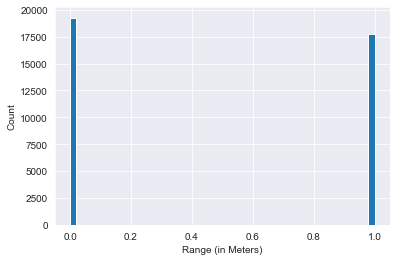

In [5]:
plt.hist(np.array(y_data).squeeze(),bins=50)
plt.xlabel("Range (in Meters)")
plt.ylabel("Count")
#plt.savefig("./Plots/cellphone_training_ranges_hist_LT80.pdf",bbox_inches="tight")

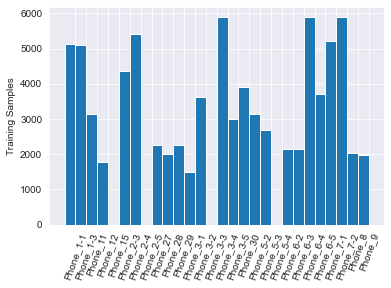

In [30]:
names=[]
count=[]
ind=np.arange(28)
width=1
for x in indiv_phone_num_dict:
    names.append(x)
    count.append(indiv_phone_num_dict[x])
bar1=plt.bar(ind,np.array(count),align='edge',width=width)
plt.xticks(ind+width,names)

plt.xticks(rotation=70)
plt.ylabel("Training Samples")
plt.savefig("./Plots/trainingDataPerPhoneHist.pdf",bbox_inches="tight")

In [5]:
a=x_data
b=y_data

Text(0.5, 0, 'Class Distribution (0=Noise, 1=sUAS)')

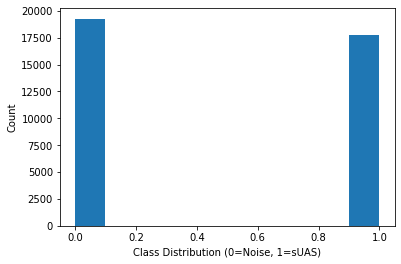

In [6]:
plt.hist(y_data)
plt.ylabel("Count")
plt.xlabel("Class Distribution (0=Noise, 1=sUAS)")
#plt.savefig("./Plots/cellphone_training_distro_hist.pdf",bbox_inches="tight")

(array([40636.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 39254.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

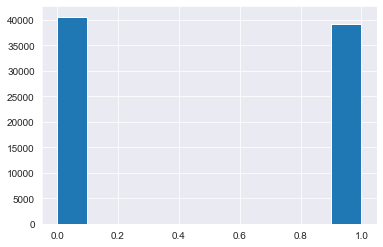

In [15]:
y_data_copy=y_data
x_data_copy=x_data
# y_data_copy.extend(labels[:,0])
# x_data_copy.extend(features)
def subsample(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=8,size=1)
        if y_data[x]==0 and rand_vals==3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x]==1:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
def subsamplesUAS(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=4,size=1)
        if y_data[x]==0 and rand_vals!=1:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x]==1:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
new_x,new_y= subsample(x_data,y_data)
plt.hist(new_y)

In [26]:
training_data=pd.read_csv("datasets/training_df_LT80m_wo_A1.csv")
# mean_std=pd.read_csv("mean_std_training_ds.csv")

In [20]:
x_data_13=[]
for x in x_data:
    x_data_13.append(x[0:21])

In [7]:
# y_data=np.array(training_data.iloc[:,1])
# x_data=np.array(training_data.iloc[:,2:42])
#x_data=training_data.iloc[:,2:22]
# mean=np.array(mean_std.loc[:,'mean'])
# std=np.array(mean_std.loc[:,'std'])
# x_data=np.array(x_data)
# y_data=np.array(y_data)
train_feats,test_feats,train_targs,test_targs=train_test_split(x_data,y_data,test_size=0.2,shuffle=True,random_state=42)
train_feats=np.array(train_feats)
train_targs=np.array(train_targs)
test_feats=np.array(test_feats)
test_targs=np.array(test_targs)
mean = train_feats.mean(axis=0)
std = train_feats.std(axis=0)
train_feats -= mean
train_feats /= std
test_feats -= mean
test_feats /= std

(array([15415.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14223.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

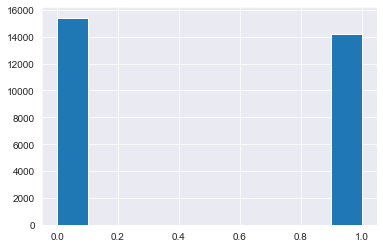

In [12]:
plt.hist(train_targs)

In [30]:
training_df=pd.DataFrame(x_data)
truth_labels_df=pd.DataFrame(y_data)
training_df_full=pd.concat([truth_labels_df,training_df],axis=1)
#training_df_full.to_csv("training_df_LT80m_test.csv")
print(mean)
print(std)
stdizer=pd.DataFrame([mean,std]).transpose()
stdizer.columns=['mean','std']
stdizer.to_csv("mean_std_training_ds_wo_A1_test_01-31.csv")

[-187.48908206  138.06350344   -3.32674518   52.64843678  -16.9386532
   28.00896864  -16.83997148   16.65250224   -7.16976499   10.46990153
    0.24436736    0.6440102     3.63449361   -6.28027624    3.8834542
   -8.47860927    4.29226622   -7.47620833    2.74208344   -7.46433095
   -1.85768496]
[86.36196128 18.8937631  28.12076199 17.5103656  17.45632223 13.65169415
 12.88763151 12.00959719 10.52976417  9.46565475  8.25287718  7.21408464
  6.97867657  6.62256165  6.07923335  6.14029998  6.08275612  6.24515169
  5.92487202  6.21214288  5.87051859]


# Naive

In [21]:
print(precision_score(test_targs,np.zeros(len(test_targs))))
print(recall_score(test_targs,np.zeros(len(test_targs))))
print(accuracy_score(test_targs,np.zeros(len(test_targs))))
print(f1_score(test_targs,np.zeros(len(test_targs))))

0.0
0.0
0.5112393316504388
0.0


C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LDA / QDA

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
lda= LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lda.fit(train_feats,train_targs)
qda.fit(train_feats,train_targs)

QuadraticDiscriminantAnalysis()

In [25]:
ldaPreds=lda.predict(test_feats)
qdaPreds=qda.predict(test_feats)
print(accuracy_score(test_targs,ldaPreds))
print(precision_score(test_targs,ldaPreds))
print(recall_score(test_targs,ldaPreds))
print(f1_score(test_targs,ldaPreds))

0.6557354925775979
0.6620887895241137
0.5813236118900729
0.6190831715693594


In [69]:
import pickle
filename = 'finalized_qda_model.sav'
pickle.dump(qda, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))

# SVM

(array([10357.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  9553.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

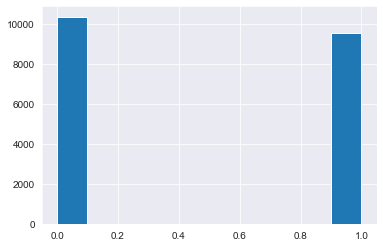

In [111]:
svmTrain_feats,_,svmTrain_targs,__=train_test_split(train_feats,train_targs,test_size=0.3,shuffle=True,random_state=42)
plt.hist(svmTrain_targs)

In [12]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

model = svm.SVC(kernel='rbf')
pipeline= Pipeline([('estimator', model)])
cv = KFold(n_splits=5)
param_grid= {
    'estimator__C':[0.1,1,10,100], 'estimator__gamma':[1,0.1,0.01]}

search = GridSearchCV(pipeline, param_grid,refit=True,verbose=3, n_jobs=-1)
print(search.fit(train_feats,train_targs))
print(search.best_params_)
print(search.best_score_)
search.score(test_feats,test_targs)
SVMmodelPreds=search.predict(test_feats)
print(precision_score(test_targs,SVMmodelPreds))
print(recall_score(test_targs,SVMmodelPreds))
print(accuracy_score(test_targs,SVMmodelPreds))
print(f1_score(test_targs,SVMmodelPreds))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV(estimator=Pipeline(steps=[('estimator', SVC())]), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10, 100],
                         'estimator__gamma': [1, 0.1, 0.01]},
             verbose=3)
{'estimator__C': 100, 'estimator__gamma': 0.1}
0.8894318223116192
0.8979414322992172
0.8815826928551096
0.8920134983127109
0.8896868715886239


In [11]:
from sklearn import svm
import time
start_time=time.time()
model = svm.SVC(kernel='rbf',C=100,gamma=0.1,probability=True)
model.fit(train_feats,train_targs)
stop_time=time.time()
print(stop_time-start_time)
print(model.n_support_)
print(model.get_params())


894.7531161308289
[10587 10246]
{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [12]:
model.score(test_feats,test_targs)
SVMmodelPreds=model.predict(test_feats)
print(precision_score(test_targs,SVMmodelPreds))
print(recall_score(test_targs,SVMmodelPreds))
print(accuracy_score(test_targs,SVMmodelPreds))
print(f1_score(test_targs,SVMmodelPreds))

0.8907228229937393
0.8777341559169939
0.8893387314439946
0.884180790960452


In [13]:
import pickle
filename = 'finalized_svm_model_02_02.sav'
pickle.dump(model, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))

# CNN Evaluation

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 160)               6560      
                                                                 
 alpha_dropout_2 (AlphaDropo  (None, 160)              0         
 ut)                                                             
                                                                 
 dense_4 (Dense)             (None, 80)                12880     
                                                                 
 alpha_dropout_3 (AlphaDropo  (None, 80)               0         
 ut)                                                             
                                                                 
 dense_55 (Dense)            (None, 40)                3240      
                                                                 
 dense_5 (Dense)             (None, 20)               

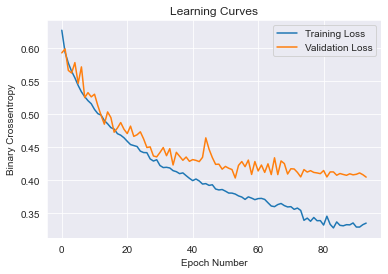

In [15]:
CNNv3=tf.keras.Sequential()
CNNv3.add(Input(shape=(40)))
CNNv3.add(Dense(160, activation='selu', name='dense_1',kernel_initializer='lecun_normal'))
CNNv3.add(AlphaDropout(0.3))
CNNv3.add(Dense(80, activation='selu', name='dense_4',kernel_initializer='lecun_normal'))
CNNv3.add(AlphaDropout(0.2))
# CNNv3.add(AlphaDropout(0.2))
CNNv3.add(Dense(40, activation='selu', name='dense_55',kernel_initializer='lecun_normal'))
CNNv3.add(Dense(20, activation='selu', name='dense_5',kernel_initializer='lecun_normal'))
CNNv3.add(Dense(20, activation='selu', name='dense_56',kernel_initializer='lecun_normal'))
CNNv3.add(Dense(10, activation='selu', name='dense_57',kernel_initializer='lecun_normal'))
CNNv3.add(Dense(1, activation='sigmoid', name='dense_6'))
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
CNNv3.summary()
CNNv3.compile(optimizer='nadam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
start_time=time.time()
history = CNNv3.fit(train_feats, train_targs,
                      epochs=500,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
print(time.time()-start_time)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()

In [28]:
CNNv3.evaluate(test_feats,test_targs)

232/232 [==============================] - 0s 1ms/step - loss: 0.4385 - accuracy: 0.8046


[0.43845927715301514, 0.8045883774757385]

In [31]:
CNNpreds=CNNv3.predict(test_feats)
CNNpreds=CNNpreds>0.5

232/232 [==============================] - 0s 788us/step


In [29]:
CNNv3.save("test_01_31")

INFO:tensorflow:Assets written to: test_01_31\assets


In [29]:
CNNpreds=CNNv3.predict(np.array(x_test_data))
CNNpreds=CNNpreds>0.75
print(precision_score(y_test_data,CNNpreds))
print(recall_score(y_test_data,CNNpreds))
print(accuracy_score(y_test_data,CNNpreds))
print(f1_score(y_test_data,CNNpreds))

1606/1606 [==============================] - 2s 1ms/step
0.6211453744493393
0.6154376292212267
0.9356119588913111
0.6182783291022386


In [41]:
from research.dataImporting import MLtools
MLtools.save_model(CNNv3,"ANN_LT80_wo_A1_24bit")

# CNN Deep Version

In [41]:
CNNv2=tf.keras.Sequential()
CNNv2.add(Input(shape=(40)))
CNNv2.add(Dense(80, activation='selu', name='dense_1',kernel_initializer='lecun_normal'))
CNNv2.add(AlphaDropout(0.3))
CNNv2.add(Dense(80, activation='selu', name='dense_2',kernel_initializer='lecun_normal'))
CNNv2.add(AlphaDropout(0.2))
CNNv2.add(Dense(80, activation='selu', name='dense_3',kernel_initializer='lecun_normal'))
# CNNv3.add(AlphaDropout(0.2))
CNNv2.add(Dense(40, activation='selu', name='dense_4',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(20, activation='selu', name='dense_5',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(20, activation='selu', name='dense_6',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(20, activation='selu', name='dense_7',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(10, activation='selu', name='dense_8',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(10, activation='selu', name='dense_9',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(5, activation='selu', name='dense_10',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(1, activation='sigmoid', name='dense_11'))
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
CNNv2.summary()
CNNv2.compile(optimizer='nadam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
history = CNNv2.fit(train_feats, train_targs,
                      epochs=500,
                      batch_size=32,
                      shuffle=True,
                        class_weight=range_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 80)                3280      
                                                                 
 alpha_dropout_6 (AlphaDropo  (None, 80)               0         
 ut)                                                             
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 alpha_dropout_7 (AlphaDropo  (None, 80)               0         
 ut)                                                             
                                                                 
 dense_3 (Dense)             (None, 80)                6480      
                                                                 
 dense_4 (Dense)             (None, 40)               


KeyboardInterrupt



In [75]:
CNNpredsv2=CNNv2.predict(test_feats)
CNNpredsv2=CNNpredsv2>0.5
print(precision_score(test_targs,CNNpredsv2))
print(recall_score(test_targs,CNNpredsv2))
print(accuracy_score(test_targs,CNNpredsv2))
print(f1_score(test_targs,CNNpredsv2))

NameError: name 'CNNv2' is not defined

# CNN Wide

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1024)              41984     
                                                                 
 alpha_dropout_4 (AlphaDropo  (None, 1024)             0         
 ut)                                                             
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 alpha_dropout_5 (AlphaDropo  (None, 512)              0         
 ut)                                                             
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 alpha_dropout_6 (AlphaDropo  (None, 256)             

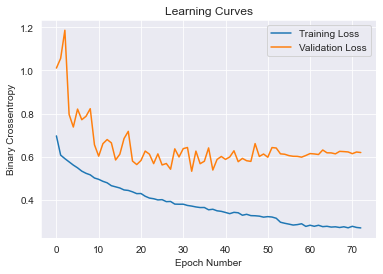

In [19]:
CNNv1=tf.keras.Sequential()
CNNv1.add(Input(shape=(40)))
CNNv1.add(Dense(1024, activation='selu', name='dense_1',kernel_initializer='lecun_normal'))
CNNv1.add(AlphaDropout(0.5))
CNNv1.add(Dense(512, activation='selu', name='dense_2',kernel_initializer='lecun_normal'))
CNNv1.add(AlphaDropout(0.4))
CNNv1.add(Dense(256, activation='selu', name='dense_3',kernel_initializer='lecun_normal'))
CNNv1.add(AlphaDropout(0.3))
CNNv1.add(Dense(1, activation='sigmoid', name='dense_6'))
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
CNNv1.summary()
CNNv1.compile(optimizer='nadam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
history = CNNv1.fit(train_feats, train_targs,
                      epochs=500,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()

In [20]:
CNNv1preds=CNNv1.predict(test_feats)
CNNv1preds=CNNv1preds>0.5
print(precision_score(test_targs,CNNv1preds))
print(recall_score(test_targs,CNNv1preds))
print(accuracy_score(test_targs,CNNv1preds))
print(f1_score(test_targs,CNNv1preds))

223/223 [==============================] - 1s 3ms/step
0.8772905759162304
0.7631653857102192
0.8302868391451068
0.8162581823717461


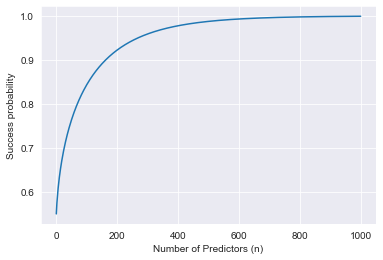

In [68]:
import math
# Law of large numbers
n_vals=[]
scores=[]
for n in range(1,1001,2):
    simp_majority=int(np.ceil(0.50*n))
    sum_val=0
    for r in range(simp_majority,n+1):
        sum_val+=math.comb(n,r)*0.55**r*(0.45**(n-r))
    n_vals.append(n)
    scores.append(sum_val)

plt.ylabel("Success probability")
plt.xlabel("Number of Predictors (n)")
plt.plot(n_vals,scores)
plt.savefig("ensemble_growth.png")